In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.interpolate as interpol
import matplotlib.pyplot as plt

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
xi = -20. #left endpont
xf = 20. #right endpoint
J = 5001 #number of space nodes
Xgrid = np.linspace(xi, xf, J)

In [4]:
x = np.load('tracks/gauss1.npy')

In [5]:
x.shape

(2, 500, 1000)

In [6]:
nt = x.shape[1]
N = x.shape[2]
T = 4 # final time
dt = T/N #time step

In [7]:
class TNet(nn.Module):

    def __init__(self):
        super(TNet, self).__init__()
        self.con1 = nn.Conv2d(2, 18, kernel_size = (1,5))
        self.con2 = nn.Conv2d(18, 36, kernel_size = (1,5))
        self.nonlin = nn.SELU()
        self.drop = nn.Dropout(0.03)
        self.fct = nn.Linear(nt, nt)
        self.final = nn.Linear(36, 1)


    def forward(self, x):
        x = self.con1(x)
        x = self.nonlin(x)
        x = self.drop(x)
        x = self.con2(x)
        x = torch.squeeze(x, 3)
        x = self.nonlin(x)
        x = self.drop(x)
        x = self.fct(x)
        x = self.nonlin(x)
        x = self.drop(x)
        x = x.transpose(1,2)
        x = self.final(x)
        x = torch.squeeze(x, 2)
        return x

In [8]:
net = TNet()
# net = net.cuda()
net.load_state_dict(torch.load('saves/tnet'))
criterion = nn.MSELoss()

In [9]:
y = np.zeros([1, 2, nt, N])

In [10]:
y[0, :, :, :9] = x[:, :, :9]

In [11]:
pot = np.load('pots/gauss1_pot.npy')

In [12]:
potent = interpol.interp1d(Xgrid, pot)

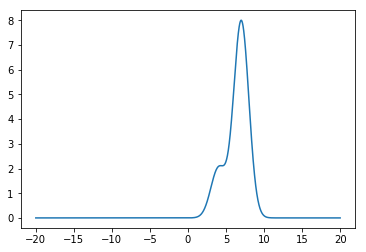

In [13]:
plt.figure()
plt.plot(Xgrid, potent(Xgrid))
plt.show()

In [14]:
for t in range(9,N):
    df_prediction = (net.forward(torch.from_numpy(y[:, :, :, t - 9: t]))).detach().numpy()
    pred = y[:, 0, :, t-1] + df_prediction
    potential = potent(np.clip(pred, -20, 20))
    together = np.stack((pred, potential), axis = 1)
    y[0, :, :, t] = together

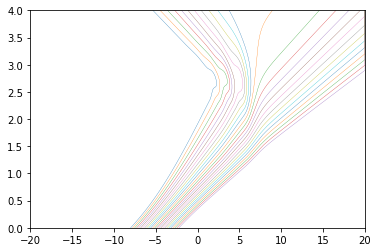

In [15]:
Tgrid = np.linspace(0, N*dt, N)
skip = 20

plt.figure()
plt.axis([xi, xf, 0, N*dt])
for l in range(nt//skip):
    plt.plot(x[0, l*skip,:],Tgrid, linewidth=0.3)
plt.show()

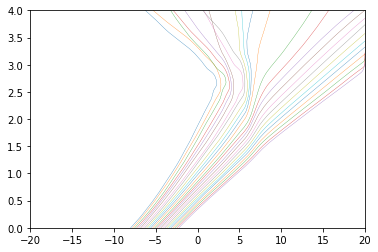

In [16]:
plt.figure()
plt.axis([xi, xf, 0, N*dt])
# for l in range(nt//skip):
for l in range(nt//skip):
    plt.plot(y[0, 0, l*skip,:],Tgrid, linewidth=0.3)
plt.show()